In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dask_ml
!pip install geopandas
!pip install rasterio
!pip install cartopy==0.19.0.post1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 7.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 6.3 MB 49.5 MB/s 
     |████████████████████████████████| 16.7 MB 359 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.1 MB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.7 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_

In [ ]:
import sys
# sys.path.append("../../")
sys.path.append('/content/drive/MyDrive/CSE 499A/gradboost')
print(sys.executable)
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler='threads')
import xarray as xr

# from python.misc.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
# from python.misc.plot import plot_multif_prediction

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.ensemble import GradientBoostingRegressor

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

/usr/bin/python3


In [ ]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import geopandas
from rasterio import features
from affine import Affine
# from python.misc.utils import calc_area
np.seterr(divide='ignore', invalid='ignore')

"""Contains methods for the flowmodel (transport model & local model)"""


def calc_area(da, resolution_degrees=None):
    """Calculate the area for each gridpoint of a 2-dimensional DataArray.

    Approximations: spherical earth, gridbox is a square of area dx*dy

    Parameters
    ----------
        da : xr.DataArray
            a 2-dimensional array with coordinates `latitude` and `longitude`

        resolution_degrees : float
            grid resolution in degrees latitude/longitude, e.g. 0.25

    Returns
    -------
    xr.DataArray
        contains the area per gridbox in m^2
    """
    km_deg = 111319  # meters per degree latitude

    if not resolution_degrees:
        if (len(da.latitude) < 2 or len(da.longitude) < 2):
            raise ValueError('Either lat or lon is singleton, cannot infer'
                             ' resolution, pass `resolution_degrees` to continue!')
        res_lat = abs(da.latitude[0].values-da.latitude[1].values)
        res_lon = abs(da.longitude[0].values-da.longitude[1].values)
    else:
        res_lat = resolution_degrees
        res_lon = resolution_degrees

    lats = da.latitude.values[:, np.newaxis]*np.ones(len(da.longitude))
    dx = km_deg*abs(np.cos(lats/90))*res_lon
    dy = km_deg*res_lat
    for var in da:
        area = dx*dy
        area = xr.DataArray(area, dims=['latitude', 'longitude'],
                            coords=dict(latitude=('latitude', da.latitude),
                                        longitude=('longitude', da.longitude)))
        area.name = 'area'
        area.attrs['units'] = 'meters'
        return area


def get_mask_of_basin(da, kw_basins='Danube'):
    """Return a mask where all points outside the selected basin are False.

    Parameters:
    -----------
    da : xr.DataArray
        contains the coordinates
    kw_basins : str
        identifier of the basin in the basins dataset
    """
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/' \
           + 'drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    da = da.basins == 0
    return da.drop('basins')  # the basins coordinate is not used anymore from here on


def select_upstream(mask_river_in_catchment, lat, lon, basin='Danube'):
    """Return a mask containing upstream river gridpoints.

    Parameters
    ----------
    mask_river_in_catchment : xr.DataArray
        array that is True only for river gridpoints within a certain catchment
        coords: only latitude and longitute

    lat, lon : float
        latitude and longitude of the considered point

    basin : str
        identifier of the basin in the basins dataset

    Returns
    -------
    xr.DataArray
        0/1 mask array with (latitude, longitude) as coordinates
    """

    # this condition should be replaced with a terrain dependent mask
    # but generally speaking, there will always be some points returned that
    # do not influence the downstream point;
    # the statistical model should ignore those points as learned from the dataset
    da = mask_river_in_catchment.load()
    is_west = (~np.isnan(da.where(da.longitude <= lon))).astype(bool)

    mask_basin = get_mask_of_basin(da, kw_basins=basin)

    nearby_mask = da*0.
    nearby_mask.loc[dict(latitude=slice(lat+1.5, lat-1.5),
                         longitude=slice(lon-1.5, lon+1.5))] = 1.
    nearby_mask = nearby_mask.astype(bool)

    mask = mask_basin & nearby_mask & is_west & mask_river_in_catchment

    if 'basins' in mask.coords:
        mask = mask.drop('basins')
    if 'time' in mask.coords:
        mask = mask.drop('time')  # time and basins dimension make no sense here
    return mask


def add_shifted_variables(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.

    Parameters
    ----------
    ds : xr.Dataset
    shifts : list(int, )
        e.g. range(1,4); shift=1 means having the value x(t=0) at t=1
    variables : str or list
        e.g. ['lsp', 'cp']

    Returns
    -------
    xr.Dataset
        the input Dataset with the shifted timeseries added as additional variable
    """
    if isinstance(ds, xr.DataArray):
        ds = ds.to_dataset()  # enforce input type

    if variables == 'all':
        variables = ds.data_vars

    for var in variables:
        for i in shifts:
            if i == 0:
                continue  # zero-shift is the original timeseries
            if i > 0:
                sign = '-'
            else:
                sign = '+'
            newvar = var+sign+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds


def shift_and_aggregate(df, shift, aggregate):
    """
    To get a predictor from [lsp(t-3), ..., lsp(t-6)],
    use shift = 3 and aggregate = 3

    Parameters
    ----------
    shift : int
    aggregate : int
    """
    return df.shift(time=shift).rolling(time=aggregate).sum()/aggregate


def aggregate_clustersum(ds, cluster, clusterdim):
    """Aggregate a 3-dimensional array over certain points (latitude, longitude).

    Parameters
    ----------
    ds : xr.Dataset
        the array to aggregate (collapse) spatially
    cluster : xr.DataArray
        3-dimensional array (clusterdim, latitude, longitude),
        `clusterdim` contains the True/False mask of points to aggregate over
        e.g. len(clusterdim)=4 means you have 4 clusters
    clusterdim : str
        dimension name to access the different True/False masks

    Returns
    -------
    xr.DataArray
        1-dimensional
    """
    out = xr.Dataset()

    # enforce same coordinates
    interp = True
    if (len(ds.latitude.values) == len(cluster.latitude.values) and
            len(ds.longitude.values) == len(cluster.longitude.values)):
        if (np.allclose(ds.latitude.values, cluster.latitude.values) and
                np.allclose(ds.longitude.values, cluster.longitude.values)):
            interp = False
    if interp:
        ds = ds.interp(latitude=cluster.latitude, longitude=cluster.longitude)
    area_per_gridpoint = calc_area(ds.isel(time=0))

    if isinstance(ds, xr.DataArray):
        ds = ds.to_dataset()

    for var in ds:
        for cl in cluster.coords[clusterdim]:
            newname = var+'_cluster'+str(cl.values)
            this_cluster = cluster.sel({clusterdim: cl})

            da = ds[var].where(this_cluster, 0.)  # no contribution from outside cluster
            out[newname] = xr.dot(da, area_per_gridpoint)
    return out.drop(clusterdim)


def cluster_by_discharge(dis_2d, bin_edges):
    """Custom clustering by discharge.
    """
    cluster = dict()
    for i in range(len(bin_edges)-1):
        cluster[str(i)] = (dis_2d >= bin_edges[i]) & (dis_2d < bin_edges[i+1])
        cluster[str(i)].attrs['units'] = None

    return xr.Dataset(cluster,
                      coords=dict(clusterId=('clusterId', range(len(bin_edges))),
                                  latitude=('latitude', dis_2d.latitude),
                                  longitude=('longitude', dis_2d.longitude)))


def reshape_scalar_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.

    Parameters
    ----------
    X_dis : xr.Dataset
        variables: time shifted predictors (name irrelevant)
        coords: time, latitude, longitude
    y : xr.DataArray
        coords: time
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if isinstance(y, xr.Dataset):
        if len(y.data_vars) > 1:
            warnings.warn('Supplied `y` with more than one variable.'
                          'Which is the predictand? Supply only one!')
        for v in y:
            y = y[v]  # use the first
            break

    yar = y
    if len(yar.dims) > 1:
        raise NotImplementedError('y.dims: '+str(yar.dims) +
                                  ' Supply only one predictand dimension, e.g. `time`!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in yar.coords:
            yar = yar.drop(coord)

    # merge times
    yar.coords['features'] = 'predictand'
    Xy = xr.concat([Xar, yar], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-1]  # last column is predictand
    yda = Xyt[:, -1].drop('features')  # features was only needed in merge
    return Xda, yda


def multiday_prediction_to_timeseries(prediction):
    """Convert a 2-dimensional xarray to 1-dimensional with nonunique time-index.

    Parameters
    ----------
    xar : xr.DataArray
        2-dimensional xarray (init_time, forecast_day)

    Returns
    -------
    xr.DataArray
        1-dimensional (time) array with nonunique time index
    """
    forecast_days = len(prediction.forecast_day)
    inits = np.array(prediction.init_time)[:, np.newaxis]

    # repeat the initial time for every forecast day in a column
    times = np.repeat(inits, forecast_days, axis=1)

    # add the forecast day to each column
    for i, day in enumerate(prediction.forecast_day.values):
        times[:, i] += np.timedelta64(day, 'D')

    times = times.ravel()
    data = prediction.values.ravel()
    return pd.Series(data, index=times)


def reshape_multiday_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.

    Parameters
    ----------
    X_dis : xr.Dataset
        variables: time shifted predictors (name irrelevant)
        coords: time, latitude, longitude
    y : xr.DataArray (multiple variables, multiple timesteps)
        coords: time, forecast_day
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if not isinstance(y, xr.DataArray):
        raise TypeError('Supply `y` as xr.DataArray.'
                        'with coords (time, forecast_day)!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in y.coords:
            y = y.drop(coord)

    out_dim = len(y.forecast_day)
    y = y.rename(dict(forecast_day='features'))  # rename temporarily
    Xy = xr.concat([Xar, y], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-out_dim]  # last column is predictand
    yda = Xyt[:, -out_dim:]  # features was only needed in merge
    yda = yda.rename(dict(features='forecast_day'))  # change renaming back to original
    return Xda, yda


def add_valid_time(pred):
    """Add a another time coordinate giving the valid time of a forecast.

    Parameters
    ----------
    pred : xr.DataArray
        2-dimensional (init_time, forecast_day)

    Returns
    -------
    xr.DataArray
        with an additional 'time' coordinate of forecast validity.
    """
    validtime = np.zeros((len(pred.init_time), len(pred.forecast_day)))
    fcst_days = pred.forecast_day.values

    # iterate over columns and add the respective number of days
    for i, fcst_day in enumerate(fcst_days):
        validtime[:, i] = pred.init_time.values + np.timedelta64(fcst_day, 'D')

    pred.coords['time'] = (('init_time', 'forecast_day'),
                           validtime.astype(np.datetime64))
    return pred


def add_future_precip(X, future_days=13):
    """Add shifted precipitation variables.

    Parameters
    ----------
    X : xr.Dataset
        containing 'lsp' and 'cp' variables
    future_days : int
        create variables that are shifted by 1 up to `future_days`-days

    Returns
    -------
    xr.Dataset
        with additional shifted variables
    """
    for var in ['lsp', 'cp']:
        for i in range(1, future_days+1):
            newvar = var+'+'+str(i)
            X[newvar] = X[var].shift(time=-i)  # future precip as current day variable


def add_future_vars(X, future_days=13):
    """Add shifted variables (from future time points) to the dataset
    for multi-day forecasts.

    Parameters
    ----------
    X : xr.Dataset
        variables: time shifted features
        coords: time
    future_days : int
    """
    if isinstance(X, xr.Dataset):
        for var in X.variables:
            if var not in 'time':
                for i in range(1, future_days+1):
                    newvar = var+'+'+str(i)
                    # future precip as current day variable
                    X[newvar] = X[var].shift(time=-i)
    else:
        raise TypeError('Input type has to be a xr.Dataset!')
    return X


def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.

    Parameters
    ----------
    vector : numpy.array
    time   : xr.DataArray
    name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


def generate_prediction_array(y_pred, y_reana, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.

    Parameters
    ----------
    y_pred          : xr.DataArray
    y_reana         : xr.DataArray
    forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:, 0] = y_reana.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)

    pred_multif = xr.DataArray(pred_multif_data_fin,
                       coords={'num_of_forecast': range(1, num_forecasts+1),
                               'forecast_day': range(0, forecast_range+1),
                               'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                       dims=['num_of_forecast', 'forecast_day'],
                       name='prediction')
    return pred_multif


def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.

    Parameters
    ----------
    x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x


def multi_forecast_case_study(pipe_case, x, y):
    """
    Convenience function for predicting discharge via the pre-trained input pipe.
    Loads glofas forecast_rerun data from a in-function set path, used to evaluate
    the model predictions.
    Outputs are 3 xr.DataArrays: One for the model forecast, one for the forecast reruns,
                                 one for the reanalysis.

    Parameters
    ----------
        pipe_case : trainer ML pipe ready for prediction
        x         : xr.DataArray
        y         : xr.DataArray

    Returns
    -------
    xr.DataArray (3 times)
    """
    y_2013 = y
    X_2013 = x
    
    multif_list = []
    multifrerun_list = []
    for forecast in range(1, 5):
        if forecast == 1:
            date_init = '2013-05-18'
            date_end = '2013-06-17'
            fr_dir = '2013051800'
        elif forecast == 2:
            date_init = '2013-05-22'
            date_end = '2013-06-21'
            fr_dir = '2013052200'
        elif forecast == 3:
            date_init = '2013-05-25'
            date_end = '2013-06-24'
            fr_dir = '2013052500'
        elif forecast == 4:
            date_init = '2013-05-29'
            date_end = '2013-06-28'
            fr_dir = '2013052900'

        X_case = X_2013.sel(time=slice(date_init, date_end)).copy()

        # not needed with the new dataset containing 1981-2016
        # X_case = X_case.drop(dim='features', labels='lsp-56-180')
        # y_case = y_2013.sel(time=slice(date_init, date_end)).copy()

        # prediction start from every nth day
        # if in doubt, leave n = 1 !!!
        n = 1
        X_pred = X_case[::n].copy()
        y_pred = pipe_case.predict(X_pred)
        y_pred = add_time(y_pred, X_pred.time, name='forecast')

        multif_case = generate_prediction_array(y_pred, y_2013, forecast_range=30)
        multif_case.num_of_forecast.values = [forecast]
        multif_list.append(multif_case)

        # add glofas forecast rerun data
        # glofas forecast rerun data
        frerun = xr.open_mfdataset(f'../../data/glofas-freruns/{fr_dir}/glof*', combine='by_coords')
        poi = dict(lat=48.35, lon=13.95)
        fr = frerun['dis'].sel(lon=slice(13.9, 14.), lat=slice(48.4, 48.3)).compute()
        fr = fr.where(~np.isnan(fr), 0).drop(labels=['lat', 'lon']).squeeze()
        multifrerun_list.append(fr)

    # merge forecasts into one big array
    date_init = '2013-05-18'
    date_end = '2013-06-28'
    y_case_fin = y_2013.sel(time=slice(date_init, date_end)).copy()
    X_case_multi_core = X_2013.sel(time=slice(date_init, date_end)
                                   ).isel(features=1).copy().drop('features')*np.nan

    X_list = []
    for fc in multif_list:
        X_iter = X_case_multi_core.copy()
        X_iter.loc[{'time': fc.time.values.ravel()}] = fc.values[0]
        X_list.append(X_iter)
    X_multif_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multif_fin.name = 'prediction'

    X_list = []
    for frr in multifrerun_list:
        X_iter = X_case_multi_core.copy()
        ens_list = []
        for fr_num in frr.ensemble:
            fr_iter = frr.sel(ensemble=fr_num)
            X_ens_iter = X_iter.copy()
            X_ens_iter.loc[{'time': frr.time.values}] = fr_iter.values
            ens_list.append(X_ens_iter)
        ens_da = xr.concat(ens_list, dim='ensemble')
        X_list.append(ens_da)
    X_multifr_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multifr_fin.name = 'forecast rerun'
    return X_multif_fin, X_multifr_fin, y_case_fin


def multi_forecast_case_study_tdnn(pipe_case):
    """
    Convenience function for predicting discharge via the pre-trained input pipe.
    Loads glofas forecast_rerun data from a in-function set path, used to evaluate
    the model predictions.
    Outputs are 3 xr.DataArrays: One for the model forecast, one for the forecast reruns,
                                 one for the truth/reanalysis.

    Parameters
    ----------
    pipe_case : trainer ML pipe ready for prediction

    Returns
    -------
    xr.DataArray (3 times)
    """
    features_2013 = xr.open_dataset('../../data/features_xy.nc')
    y = features_2013['dis']
    X = features_2013.drop(['dis', 'dis_diff'])

    X, y = reshape_scalar_predictand(X, y)

    multif_list = []
    multifrerun_list = []
    for forecast in range(1, 5):
        if forecast == 1:
            date_init = '2013-05-18'
            date_end = '2013-06-17'
            fr_dir = '2013051800'
        elif forecast == 2:
            date_init = '2013-05-22'
            date_end = '2013-06-21'
            fr_dir = '2013052200'
        elif forecast == 3:
            date_init = '2013-05-25'
            date_end = '2013-06-24'
            fr_dir = '2013052500'
        elif forecast == 4:
            date_init = '2013-05-29'
            date_end = '2013-06-28'
            fr_dir = '2013052900'

        X_case = X.sel(time=slice(date_init, date_end)).copy()

        # prediction start from every nth day
        # if in doubt, leave n = 1 !!!
        n = 1
        X_pred = X_case[::n].copy()
        y_pred = pipe_case.predict(X_pred)

        multif_case = generate_prediction_array(y_pred, y, forecast_range=30)
        multif_case.num_of_forecast.values = [forecast]
        multif_list.append(multif_case)

        # add glofas forecast rerun data
        # glofas forecast rerun data
        frerun = xr.open_mfdataset(f'../../data/glofas-freruns/{fr_dir}/glof*',
                                   combine='by_coords')
        fr = frerun['dis'].sel(lon=slice(13.9, 14.), lat=slice(48.4, 48.3))
        fr = fr.drop(labels=['lat', 'lon']).squeeze()
        multifrerun_list.append(fr)

    # merge forecasts into one big array
    date_init = '2013-05-18'
    date_end = '2013-06-28'
    y_case_fin = y.sel(time=slice(date_init, date_end)).copy()
    X_case_multi_core = X.sel(time=slice(date_init, date_end)
                              ).isel(features=1).copy().drop('features')*np.nan

    X_list = []
    for fc in multif_list:
        X_iter = X_case_multi_core.copy()
        X_iter.loc[{'time': fc.time.values.ravel()}] = fc.values[0]
        X_list.append(X_iter)
    X_multif_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multif_fin.name = 'prediction'

    X_list = []
    for frr in multifrerun_list:
        X_iter = X_case_multi_core.copy()
        ens_list = []
        for fr_num in frr.ensemble:
            fr_iter = frr.sel(ensemble=fr_num)
            X_ens_iter = X_iter.copy()
            X_ens_iter.loc[{'time': frr.time.values}] = fr_iter.values
            ens_list.append(X_ens_iter)
        ens_da = xr.concat(ens_list, dim='ensemble')
        X_list.append(ens_da)
    X_multifr_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multifr_fin.name = 'forecast rerun'
    return X_multif_fin, X_multifr_fin, y_case_fin


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import seaborn as sns
import xarray as xr


def choose_proj_from_xar(da):
    lon = da.coords['longitude'].values
    lat = da.coords['latitude'].values
    lon_center = lon[int(len(lon)/2)]
    lat_center = lat[int(len(lat)/2)]
    if np.abs(lat.mean()) > 30:
        return ccrs.Mercator(central_longitude=lon_center, min_latitude=lat.min()-1,
                             max_latitude=lat.max()+1, globe=None,
                             latitude_true_scale=lat_center)

#        return ccrs.LambertConformal(central_longitude=lon_center,
#                                     central_latitude=lat.mean())
    else:
        return ccrs.PlateCarree(central_longitude=lon_center)


class Map(object):
    """Configures a spatial map with riverlines and major drainage basins."""
    def __init__(self, projection=None, transform=ccrs.PlateCarree(),
                 figure_kws=dict(), drainage_baisins=True):
        """Set projection, transform and figure keywords for the spatial map.

        Parameters
        ----------
        projection : cartopy.crs projection
            if None, use Mercator (old: LambertConformal) for midlatitudes and
            PlateCarree for tropics
        transform : cartopy.crs projection
            default is PlateCarree
        figure_kws : dict
            is passed on to plt.figure()
        drainage_baisins : bool
            if True, plots drainage baisins from worldbank.org (Jul 20, 2018)

        Usage Example
        ----------
        >>> m = Map(figure_kws=dict(figsize=(15,10)))
        >>> fig, ax = m.plot(xar)
        """
        self.proj = projection
        self.transform = transform
        self.fig_kws = figure_kws
        self.drainage_baisins = drainage_baisins

    def plot(self, xar, **kwargs):
        """Wraps xr.DataArray.plot.pcolormesh and formats the plot as configured
        in the call to Map().

        title is xar.long_name
        cbar_label is xar.units

        Parameters
        ----------
        xar : xr.DataArray
            two-dimensional data array
        kwargs : dict
            are passed on to xr.DataArray.plot.pcolormesh()

        Returns
        ----------
        fig : matplotlib.pyplot.figure
        ax : matplotlib.pyplot.axis
        """
        for dim in ['longitude', 'latitude']:
            if dim not in xar.coords:
                raise KeyError(dim+' not found in coordinates!')

        plt.close()
        fig = plt.figure(**self.fig_kws)

        if not self.proj:
            self.proj = choose_proj_from_xar(xar)
        ax = plt.axes(projection=self.proj)

        countries = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_0_boundary_lines_land',
            scale='50m',
            facecolor='none')
        rivers = cfeature.NaturalEarthFeature(scale='50m', category='physical',
                                              name='rivers_lake_centerlines',
                                              edgecolor='blue', facecolor='none')

        ax.add_feature(countries, edgecolor='grey')
        ax.coastlines('50m')
        ax.add_feature(rivers, edgecolor='blue')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlabels_top = False

        if self.drainage_baisins:
            sf = Reader("../data/drainage_basins/Major_Basins_of_the_World.shp")
            shape_feature = ShapelyFeature(sf.geometries(),
                                           self.transform, edgecolor='black')
            ax.add_feature(shape_feature, facecolor='none', edgecolor='green')

        # cbar_kwargs = kwargs.pop('cbar_kwargs', dict())
        subplot_kws = kwargs.pop('subplot_kws', dict())
        subplot_kws['projection'] = self.proj

        # choose which colormap to use: pos and neg values => RdYlGn, else inferno
        if ((xar.max()-xar.min()) > xar.max()):
            cmap = 'RdYlGn'
        else:
            cmap = 'spring_r'

        # colorbar preset to match height of plot
        # if 'fraction' not in cbar_kwargs: cbar_kwargs['fraction'] = 0.015
        xar.plot.pcolormesh(ax=ax, transform=self.transform,
                            subplot_kws=subplot_kws,
                            cmap=cmap,
                            **kwargs)
        return fig, ax

    def plot_point(self, ax, lat, lon):
        ax.plot(lon, lat, color='cyan', marker='o',
                markersize=20, mew=4, markerfacecolor='none',
                transform=self.transform)


def plot_ts(da, key):
    """Plot a times series for a given xarray dataarray.

    Parameters
    ----------
    da : xr.DataArray
        one-dimensional data array
    key : str
        parameter name / ylabel
    """
    p = sns.lineplot(data=da.to_pandas(), linewidth=2)
    p.set_xlabel('time')
    p.set_ylabel(key)

# ########## Model plotting


def plot_recurrent(ax, reana, prediction, each_N=7):
    """Plot predictions of recurrent nets.

    Parameters
    ----------
    ax : matplotlib axes object
    reana : xr.DataArray
        one-dimensional data array (time,)
    prediction : xr.DataArray
        two-dimensional data array of (init_time, forecast_day)
    """
    reana.plot(label='reanalysis', linewidth=2, ax=ax)
    times = prediction.init_time
    for i, init in enumerate(times):
        if not i % each_N == 0:
            continue

        da = prediction.sel(init_time=init)
        time = [pd.Timestamp(da.coords['init_time'].values)
                + dt.timedelta(days=int(i)) for i in da.coords['forecast_day'].values]

        df = pd.Series(da.values, index=time)
        df.plot(ax=ax, label=str(init))
    ax.legend(['reanalysis', 'prediction'])


def feature_importance_plot(xda_features, score_decreases):
    """Bar chart of importances.
    xda_features : xr.DataArray.features
    score_decreases : list of np.arrays
    """
    labels = [e[0] for e in xda_features.values]
    n_iter = len(score_decreases)
    width = 1/n_iter
    plt.subplots(figsize=(20, 5))

    for c in range(n_iter):
        x = np.arange(len(labels))+c/n_iter
        plt.bar(x, score_decreases[c], width=-width, align='edge')

    plt.grid()
    plt.xticks(ticks=x, labels=labels, rotation=45)


def plot_multif_prediction(pred_multif, y_reana, forecast_range=14, title=None):
    """Convenience function for plotting multiforecast shaped prediction and reanalysis.

    Note when using the returned 'ax' variable to plot additional lines outside of
    the function the corresponding objects need to be pd.Series (xr.DataArray objects
    will not be plotted onto the axis)!

    Parameters
    ----------
        pred_multif     : xr.DataArray
        y_reana         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    y_reana.sel({'time': pred_multif.time.values.ravel()}
                ).to_pandas().plot(ax=ax, label='GloFAS Reanalysis')

    pdseries = pd.Series(data=pred_multif.sel(num_of_forecast=1).values,
                         index=pred_multif.sel(num_of_forecast=1).time.values)
    pdseries.plot(ax=ax, label='Model')
    plt.legend()
    for i in pred_multif.num_of_forecast[1:]:
        fcst = pd.Series(data=pred_multif.sel(num_of_forecast=i).values,
                         index=pred_multif.sel(num_of_forecast=i).time.values)
        fcst.plot(ax=ax)

    ax.set_ylabel('river discharge [m$^3$/s]')

    y_o = y_reana.loc[{'time': pred_multif.time.values.ravel()}].values
    y_m = pred_multif.values.ravel()

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

    plt.title(f"{title} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)} |")
    return fig, ax

In [ ]:
# load data
features = xr.open_dataset('/content/drive/MyDrive/499A/Dataset/features_xy.nc')
y = features['dis']
X = features.drop(['dis', 'dis_diff'])

In [ ]:
features

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables: (12/18)
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    ...          ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

In [ ]:
dis_shift_switch = False

In [ ]:
abs_vals_switch = False

Begin with some short preprocessing..

In [ ]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [ ]:
X_base = X.to_array(dim='features').T.copy()
y_base = y.copy()

In [ ]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [ ]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [ ]:
X_train.shape, y_train.shape

((9131, 16), (9131,))

In [ ]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

In [ ]:
model = GradientBoostingRegressor(n_estimators=200,
                                  learning_rate=0.1,
                                  max_depth=5,
                                  random_state=0,
                                 # loss='ls'
                                 )

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

X_fit = Xda.copy()
y_fit = yda.copy()
pipe.fit(X_fit, y_fit)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  27.3s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           random_state=0))],
         verbose=True)

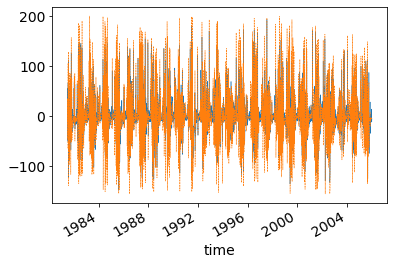

In [ ]:
Xda_insample = Xda.copy()
insample_check = pipe.predict(Xda_insample)
insample_check = add_time(insample_check, Xda.index, name='forecast')
insample_check.to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

In [ ]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n].copy()
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)

<xarray.DataArray 'forecast' (time: 2191)>
array([  3.55149751,  -3.01975441,  -6.09167696, ..., -12.92858757,
        -9.21004192,  -3.13883497])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2011-12-31


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


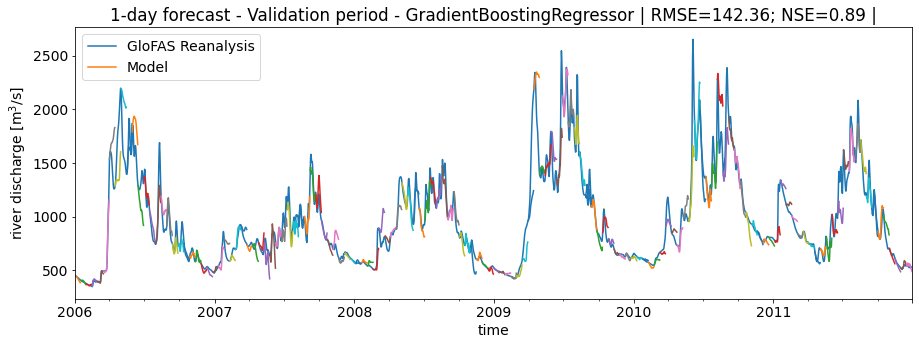

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
multif = generate_prediction_array(y_pred, y, forecast_range=14)  #was 14
plot_multif_prediction(multif, y, forecast_range=14, title='1-day forecast - Validation period - GradientBoostingRegressor');
plt.savefig('validation_period_gradboost.png', dpi=600, bbox_inches='tight')

#### Check the skill of a 14-day persistence forecast:

In [ ]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=210.1; NSE=0.75


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4e21f64a50>)

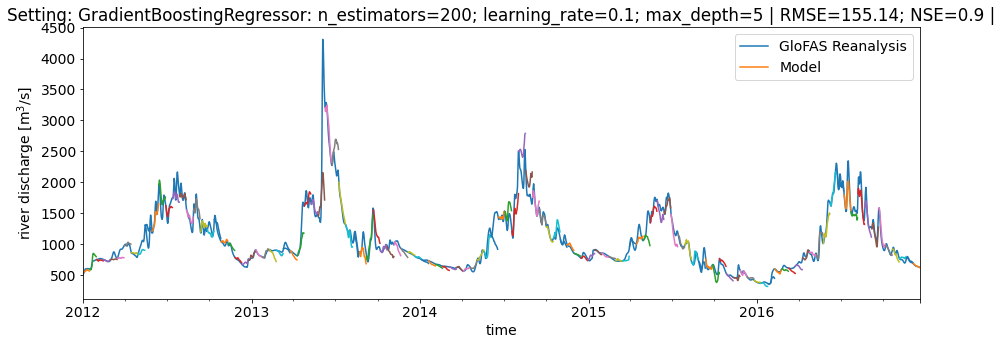

In [ ]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_test[::n].copy()
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

multif_test = generate_prediction_array(y_pred, y, forecast_range=14)   #was 14
plot_multif_prediction(multif_test, y, forecast_range=14, title='Setting: GradientBoostingRegressor: n_estimators=200; learning_rate=0.1; max_depth=5')